In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from scipy import stats
from scipy.special import boxcox1p
import warnings
warnings.filterwarnings("ignore") # To ignore warnings
pd.set_option('display.float_format', lambda x: '{:.5f}'.format(x))

# Data preparation, exploration, visualization

In [2]:
train = pd.read_csv('house-prices-advanced-regression-techniques//train.csv')
test = pd.read_csv('house-prices-advanced-regression-techniques//test.csv')

In [3]:
train.shape
test.shape

(1460, 81)

(1459, 80)

### Outlier Removal

In [4]:
min_percentile= 0.001
max_percentile= 0.999

features = ['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'MasVnrArea','BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 
            'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 
            'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal']
target= 'SalePrice'
nrows= int(np.ceil(len(features)/2))
ncols= 2 

def detect_and_remove_outliers(inline_delete= True):
    global train
    outliers = []
    for i in features:
        min_thresold, max_thresold = train[i].quantile([min_percentile, max_percentile])
        df_outliers = train[(train[i] < min_thresold) | (train[i] > max_thresold)]
        outliers = outliers + df_outliers.index.tolist()
        if inline_delete: 
            train = train.drop(df_outliers.index.tolist())
            train.reset_index(drop = True, inplace = True)

    unique_outliers= list(set(outliers))
    
    if inline_delete == False: 
        # Drop the unique outliers from final list
        print(f'Shape of train data= {train.shape}')
        train = train.drop(unique_outliers)
        train.reset_index(drop = True, inplace = True)
        print(f'Shape of train data= {train.shape}')
   
        
detect_and_remove_outliers(inline_delete= False)

Shape of train data= (1460, 81)
Shape of train data= (1417, 81)


In [5]:
train.shape
test.shape

(1417, 81)

(1459, 80)

### Removing extra columns, data type changes, imputation

In [6]:
def preprocess(df):
    df.reset_index(drop=True)
#Remove columns
    df.drop(['Id', 'Utilities', 'Street', 'PoolQC'], inplace= True, axis=1)
#data type change
    for col in ('MSSubClass', 'YrSold', 'MoSold'):
        df[col] = df[col].astype(str)
#impute categorical with None
    for col in ('MiscFeature', 'Alley','FireplaceQu', 'GarageFinish', 'GarageQual', 'Fence', 'GarageType', 'GarageQual', 'GarageCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'MasVnrType', 'MSSubClass'):
        df[col] = df[col].fillna('None')
#impute 'LotFrontage' with median of neighborhood
    df['LotFrontage'] = df.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))
#impute numerical features with 0
    for col in ('GarageYrBlt', 'GarageArea', 'GarageCars', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'MasVnrArea'):
        df[col] = df[col].fillna(0)
#impute feats with very few missing values with mode
    for col in ('MSZoning','Electrical','KitchenQual','Exterior1st','Exterior2nd', 'SaleType', 'Functional'):
        df[col] = df[col].fillna(df[col].mode()[0])
    return df

In [7]:
train=preprocess(train)
test=preprocess(test)

In [8]:
train.shape
test.shape

(1417, 77)

(1459, 76)

### Multicollinearity - VIF

In [9]:
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from statsmodels.tools.tools import add_constant

numeric_vars = train.dtypes[train.dtypes != "object"].drop('SalePrice').index

def get_vif(df, thresh=5):
    #get dataframe with only numeric features
    df_numeric = df[numeric_vars]
    #add a column of constant
    const = add_constant(df_numeric)
    cols = const.columns
    #setup output dataframe
    vif_df = pd.DataFrame()
    vif_df['feature'] = const.columns
    #calculate VIF for each feature
    vif_df['VIF'] = [(variance_inflation_factor(const.values, i)) for i in range(const.shape[1])]
    vif_df = vif_df.sort_values(by='VIF', ascending=False)
    #drop row from const
    vif_df = vif_df[vif_df['feature'] != 'const']
    #get top features above the threshold VIF
    vif_df = vif_df[vif_df['VIF'] > thresh]
    return vif_df

In [10]:
get_vif(train)

,feature,VIF
14,LowQualFinSF,inf
8,BsmtFinSF1,inf
15,GrLivArea,inf
13,2ndFlrSF,inf
12,1stFlrSF,inf
11,TotalBsmtSF,inf
10,BsmtUnfSF,inf
9,BsmtFinSF2,inf
25,GarageCars,6.13706
26,GarageArea,5.21984


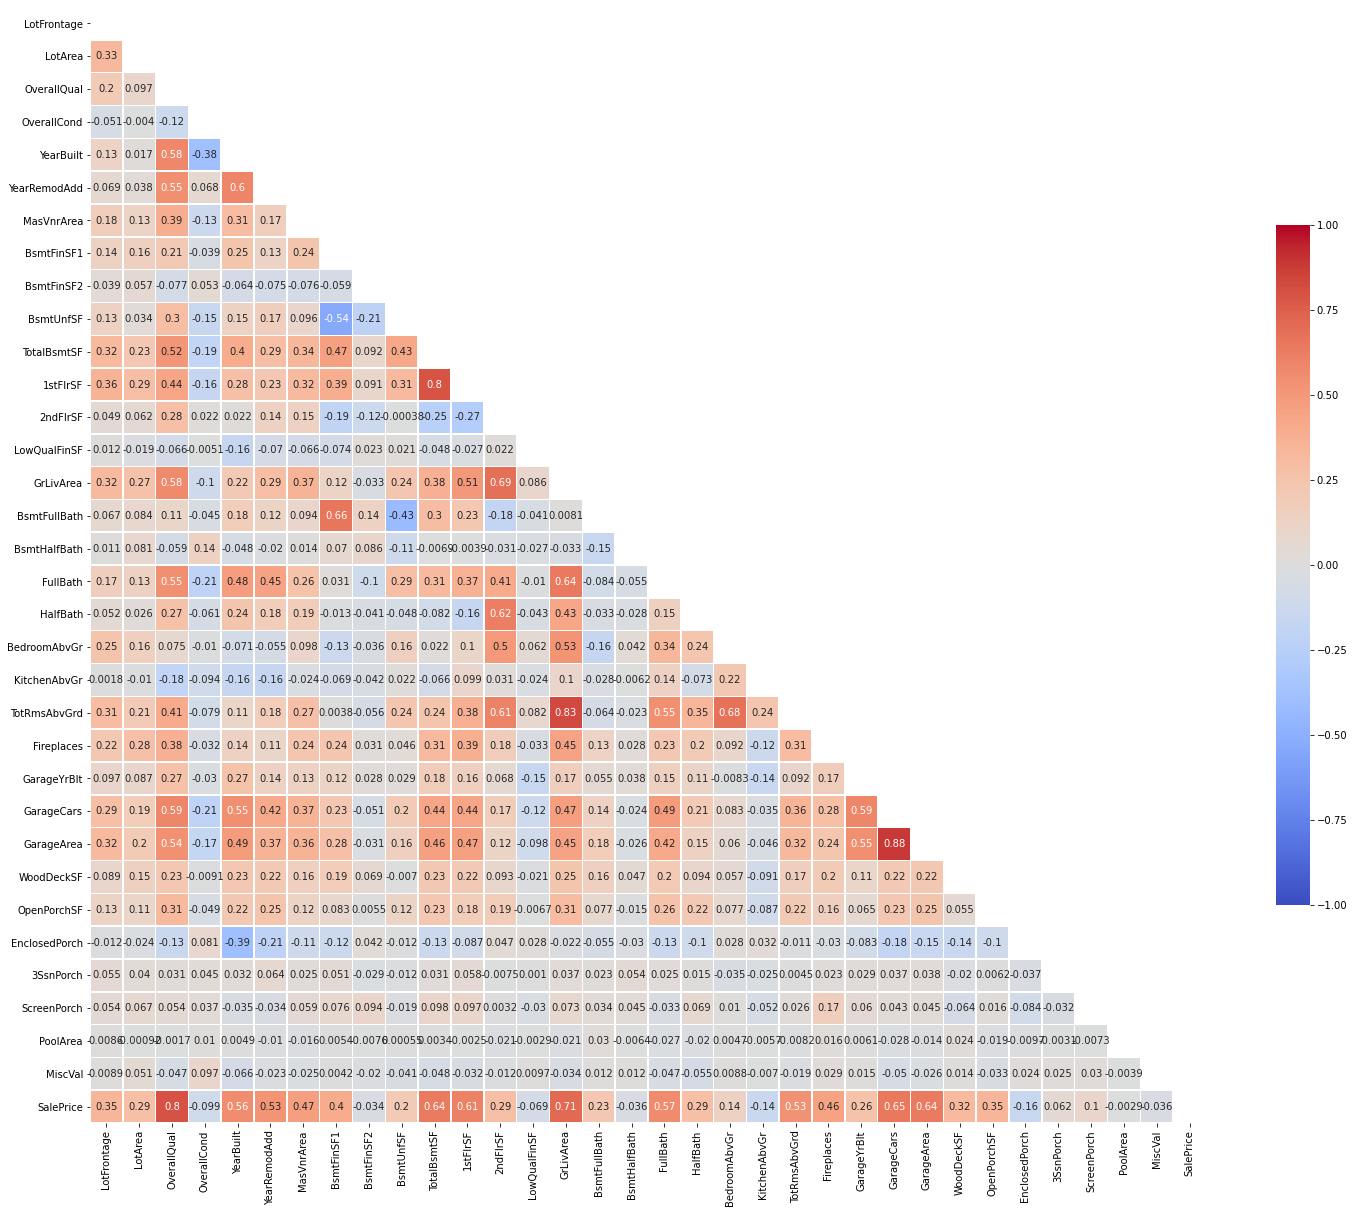

In [11]:
train_corr = train.corr(method= 'pearson')
f, ax = plt.subplots(figsize=(25, 25))
mask = np.triu(np.ones_like(train_corr, dtype=bool))
cmap=sns.color_palette("coolwarm", as_cmap=True)
ax = sns.heatmap(train_corr, vmin=-1, vmax=1, mask=mask, cmap=cmap, center=0, annot = True, square=True, linewidths=.5, cbar_kws= {"shrink": .5, 'orientation': 'vertical'})

In [12]:
train.corr().nlargest(15, 'SalePrice')['SalePrice']

SalePrice      1.00000
OverallQual    0.79930
GrLivArea      0.71216
GarageCars     0.65048
TotalBsmtSF    0.63908
GarageArea     0.63773
1stFlrSF       0.61014
FullBath       0.56671
YearBuilt      0.55762
TotRmsAbvGrd   0.53455
YearRemodAdd   0.53122
MasVnrArea     0.47223
Fireplaces     0.45972
BsmtFinSF1     0.39993
LotFrontage    0.34973
Name: SalePrice, dtype: float64

In [13]:
#drop LowQualFinSF
train = train.drop(['LowQualFinSF'], axis=1)
test = test.drop(['LowQualFinSF'], axis=1)

In [14]:
train.shape
test.shape

(1417, 76)

(1459, 75)

### Feature scaling

In [15]:
train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Alley,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,...,ScreenPorch,PoolArea,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.00000,8450,None,Reg,Lvl,Inside,Gtl,CollgCr,...,0,0,None,None,0,2,2008,WD,Normal,208500
1,20,RL,80.00000,9600,None,Reg,Lvl,FR2,Gtl,Veenker,...,0,0,None,None,0,5,2007,WD,Normal,181500
2,60,RL,68.00000,11250,None,IR1,Lvl,Inside,Gtl,CollgCr,...,0,0,None,None,0,9,2008,WD,Normal,223500
3,70,RL,60.00000,9550,None,IR1,Lvl,Corner,Gtl,Crawfor,...,0,0,None,None,0,2,2006,WD,Abnorml,140000
4,60,RL,84.00000,14260,None,IR1,Lvl,FR2,Gtl,NoRidge,...,0,0,None,None,0,12,2008,WD,Normal,250000


In [29]:
y_train = np.log1p(train['SalePrice'])

In [16]:
all_data = pd.concat((train,test)).reset_index(drop = True) #  Drops the current index of the DataFrame and replaces it with an index of increasing integers

In [17]:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].drop('SalePrice').index
skew_features = all_data[numeric_feats].apply(lambda x: stats.skew(x)).sort_values(ascending=False)
skewness = pd.DataFrame({'Skew': skew_features})
skewness.head(10)

,Skew
MiscVal,26.07865
PoolArea,25.08919
3SsnPorch,10.52828
LotArea,8.80695
KitchenAbvGr,4.26004
BsmtFinSF2,4.12285
EnclosedPorch,3.96434
BsmtHalfBath,3.84860
ScreenPorch,3.82988
MasVnrArea,2.42099


In [2]:
def boxcox_scaling(df):
    numeric_vars = df.dtypes[df.dtypes != 'object']
    skewed_features = pd.DataFrame({'skew':df['numeric_vars'].apply(lambda x: sp.stats.skew(x)).sort_values(ascending=False)})
    high_skew = skewed_features[skewed_features['skew'] > 0.5].index
    
    for col in high_skew:
        df[col]= boxcox1p(df[col], sp.stats.boxcox_normmax(df[col] + 1))
    
    return df

In [30]:
numeric_vars = all_data.dtypes[all_data.dtypes != "object"]

skew_features = all_data[numeric_feats].apply(lambda x: stats.skew(x)).sort_values(ascending=False)
skewness = pd.DataFrame({'Skew':all_data[numeric_vars.index].apply(lambda x: stats.skew(x)).sort_values(ascending=False)})
skewed = skewness[skewness['Skew'] > 0.5].index

for col in skewed:
    all_data[col] = boxcox1p(all_data[col], stats.boxcox_normmax(all_data[col]+1))
    
skew_features['After Box-Cox'] = all_data[numeric_vars.index].apply(lambda x: stats.skew(x)).sort_values(ascending=False)
skew_features

train = all_data[:len(y_train)]
test = all_data[len(y_train):].drop(['SalePrice'], axis=1)

PoolArea                                                  20.30756
3SsnPorch                                                  9.01979
MiscVal                                                    5.36302
KitchenAbvGr                                               3.95369
BsmtHalfBath                                               3.77431
ScreenPorch                                                3.15100
BsmtFinSF2                                                 2.59096
EnclosedPorch                                              2.13757
MasVnrArea                                                 0.96620
2ndFlrSF                                                   0.89297
WoodDeckSF                                                 0.78398
HalfBath                                                   0.72954
OpenPorchSF                                                0.61999
BsmtFullBath                                               0.60353
Fireplaces                                                 0.5

In [31]:
train.shape
test.shape

(1417, 76)

(1459, 75)

### Feature engineering

In [32]:
def aggregate_features(df):
    df['TotalSF'] = df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF']
    df['TotalSF1'] = df['BsmtFinSF1'] + df['BsmtFinSF2'] + df['1stFlrSF'] + df['2ndFlrSF']
    df['YrBuiltRemod']= df['YearBuilt'] + df['YearRemodAdd']
    df['TotalBath'] = (df['FullBath'] + (0.5 * df['HalfBath']) +
                                  df['BsmtFullBath'] + (0.5 * df['BsmtHalfBath']))
    df['TotalPorch'] = (df['OpenPorchSF'] + df['3SsnPorch'] + df['EnclosedPorch'] 
                            + df['ScreenPorch'] + df['WoodDeckSF'])
    df['hasPool'] = df['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
    df['has2ndFlr'] = df['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
    df['hasGarage'] = df['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
    df['hasBsmt'] = df['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
    df['hasFireplace'] = df['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)
    return df

In [33]:
def ordinal_label(df):
    df['Alley'].replace(to_replace = ['None', 'Grvl', 'Pave'], value = [0, 1, 2], inplace = True)
    df['LotShape'].replace(to_replace = ['Reg', 'IR1', 'IR2', 'IR3'], value = [3, 2, 1,0], inplace = True)
    df['LandContour'].replace(to_replace = ['Lvl', 'Bnk', 'Low', 'HLS'], value = [3, 2, 1,0], inplace = True)
    df['LotConfig'].replace(to_replace = ['Inside', 'FR2', 'Corner', 'CulDSac', 'FR3'], value = [0, 3, 1, 2, 4], inplace = True)
    df['LandSlope'].replace(to_replace = ['Gtl', 'Mod', 'Sev'], value = [2, 1, 0], inplace = True)
    df['BldgType'].replace(to_replace = ['1Fam', '2fmCon', 'Duplex', 'TwnhsE', 'Twnhs'], value = [4, 3, 2, 1, 0], inplace = True)
    df['RoofStyle'].replace(to_replace = ['Gable', 'Hip', 'Gambrel', 'Mansard', 'Flat', 'Shed'], value = [4, 2, 3, 1, 5, 0], inplace = True)
    df['RoofMatl'].replace(to_replace = ['ClyTile', 'CompShg', 'Membran', 'Metal', 'Roll', 'Tar&Grv', 'WdShake', 'WdShngl'], value = [7, 6, 5, 4, 3, 2, 1, 0], inplace = True)
    df['ExterQual'].replace(to_replace = ['Ex', 'Gd', 'TA', 'Fa'], value = [3, 2, 1, 0], inplace = True)
    df['ExterCond'].replace(to_replace = ['Ex', 'Gd', 'TA', 'Fa', 'Po'], value = [4, 3, 2, 1, 0], inplace = True)
    df['BsmtQual'].replace(to_replace = ['Ex', 'Gd', 'TA', 'Fa', 'None'], value = [4, 3, 2, 1, 0], inplace = True)
    df['BsmtCond'].replace(to_replace = ['Gd', 'TA', 'Fa', 'Po', 'None'], value = [4, 3, 2, 1, 0], inplace = True)
    df['BsmtExposure'].replace(to_replace = ['Gd', 'Av', 'Mn', 'No', 'None'], value = [4, 3, 2, 1, 0], inplace = True)
    df['BsmtFinType1'].replace(to_replace = ['GLQ', 'ALQ', 'BLQ', 'Rec', 'LwQ', 'Unf', 'None'], value = [6, 5, 4, 3, 2, 1, 0], inplace = True)
    df['BsmtFinType2'].replace(to_replace = ['GLQ', 'ALQ', 'BLQ', 'Rec', 'LwQ', 'Unf', 'None'], value = [6, 5, 4, 3, 2, 1, 0], inplace = True)
    df['HeatingQC'].replace(to_replace = ['Ex', 'Gd', 'TA', 'Fa', 'Po'], value = [4, 3, 2, 1, 0], inplace = True)
    df['KitchenQual'].replace(to_replace = ['Ex', 'Gd', 'TA', 'Fa'], value = [3, 2, 1, 0], inplace = True)
    df['Functional'].replace(to_replace = ['Typ', 'Min1', 'Min2', 'Mod',  'Maj1', 'Maj2', 'Sev'], value = [6, 5, 4, 3, 2, 1, 0], inplace = True)
    df['FireplaceQu'].replace(to_replace = ['Ex', 'Gd', 'TA', 'Fa', 'Po', 'None'], value = [5, 4, 3, 2, 1, 0], inplace = True)
    df['GarageType'].replace(to_replace = ['2Types', 'Attchd', 'Basment', 'BuiltIn', 'CarPort', 'Detchd', 'None'], value = [6, 5, 4, 3, 2, 1, 0], inplace = True)
    df['GarageFinish'].replace(to_replace = ['Fin', 'RFn', 'Unf', 'None'], value = [3, 2, 1, 0], inplace = True)
    df['GarageQual'].replace(to_replace = ['Ex', 'Gd', 'TA', 'Fa', 'Po', 'None'], value = [5, 4, 3, 2, 1, 0], inplace = True)
    df['GarageCond'].replace(to_replace = ['Ex', 'Gd', 'TA', 'Fa',  'Po', 'None'], value = [5, 4, 3, 2, 1, 0], inplace = True)
    df['PavedDrive'].replace(to_replace = ['Y', 'P', 'N'], value = [2, 1, 0], inplace = True)
    df['Fence'].replace(to_replace = ['GdPrv', 'MnPrv', 'GdWo', 'MnWw', 'None'], value = [4, 3, 2, 1, 0], inplace = True)
    return df

In [34]:
nominal_vars = ['MSSubClass', 'MSZoning', 'Neighborhood', 'Condition1', 'Condition2', 'HouseStyle', 'CentralAir', 'MiscFeature', 'MoSold', 'YrSold', 'SaleType', 'SaleCondition', 'Electrical', 'MasVnrType', 'Exterior1st', 'Exterior2nd', 'Heating', 'Foundation']

def nominal_feats(df):
    df1=pd.get_dummies(df[nominal_vars], drop_first=True)
    df=df.drop(nominal_vars, axis='columns')
    df=pd.concat([df, df1], axis='columns')
    return df

In [35]:
train = aggregate_features(train)
train.shape
train = ordinal_label(train)
train.shape
train = nominal_feats(train)
train.shape

test = aggregate_features(test)
test = ordinal_label(test)
test = nominal_feats(test)
test.shape

(1417, 86)

(1417, 86)

(1417, 208)

(1459, 200)

In [36]:
for i in train.columns.tolist():
    if i != 'SalePrice':
        if i not in test.columns.tolist():
            test[i]=0   
for i in test.columns.tolist():
    if i not in train.columns.tolist():
            train[i]=0   
            
train.shape
test.shape

(1417, 210)

(1459, 209)

In [37]:
train.head()

,LotFrontage,LotArea,Alley,LotShape,LandContour,LotConfig,LandSlope,BldgType,OverallQual,OverallCond,...,Heating_Grav,Heating_OthW,Heating_Wall,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,MSSubClass_150,MiscFeature_None
0,26.82939,20.73562,0,3,3,0,2,4,7,3.86463,...,0,0,0,0,1,0,0,0,0,0
1,31.30131,21.30226,0,3,3,3,2,4,6,5.75822,...,0,0,0,1,0,0,0,0,0,0
2,27.74494,22.02332,0,2,3,0,2,4,7,3.86463,...,0,0,0,0,1,0,0,0,0,0
3,25.27687,21.27884,0,2,3,1,2,4,7,3.86463,...,0,0,0,0,0,0,0,0,0,0
4,32.45298,23.13674,0,2,3,3,2,4,8,3.86463,...,0,0,0,0,1,0,0,0,0,0


In [38]:
y_train = np.log1p(train['SalePrice'])
x_train= train.drop(['SalePrice'], axis=1)

In [39]:
y_train = pd.DataFrame(y_train)

In [40]:
x_train.to_csv('house-prices-advanced-regression-techniques/x_train_clean.csv', index=False)
test.to_csv('house-prices-advanced-regression-techniques/test_clean.csv', index=False)
y_train.to_csv('house-prices-advanced-regression-techniques/y_train_clean.csv', index=False)

# Modeling

In [41]:
import re
from sklearn.model_selection import KFold, cross_val_score, train_test_split,  GridSearchCV

from sklearn import pipeline
from sklearn import preprocessing

from sklearn.linear_model import LinearRegression,ElasticNet, Lasso, BayesianRidge, Ridge
from sklearn import svm
from sklearn.ensemble import  GradientBoostingRegressor
from lightgbm import LGBMRegressor

from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import RFE

In [42]:
x_train=pd.read_csv('house-prices-advanced-regression-techniques/x_train_clean.csv')
test=pd.read_csv('house-prices-advanced-regression-techniques/test_clean.csv')
y_train=pd.read_csv('house-prices-advanced-regression-techniques/y_train_clean.csv')

In [43]:
y_train.shape
x_train.shape

(1417, 1)

(1417, 209)

In [44]:
kf = KFold(n_splits= 5, shuffle=True)
def rmse(model, x, y):
    rmse = np.sqrt(-cross_val_score(model, x, y, scoring="neg_mean_squared_error", cv=kf))
    print('mean=', rmse.mean(), "std=", rmse.std())

### OLS Linear regression

In [52]:
linear_reg = pipeline.Pipeline([("scaling", preprocessing.RobustScaler()), \
                               ("linear", LinearRegression())])
rmse(linear_reg, x_train, y_train)
linear_reg.fit(x_train, y_train)
y_linear = linear_reg.predict(test)
y_pred = np.expm1(y_linear)

mean= 0.11654729074745358 std= 0.004846592525346105


Pipeline(steps=[('scaling', RobustScaler()), ('linear', LinearRegression())])

In [53]:
submission = pd.read_csv("house-prices-advanced-regression-techniques/sample_submission.csv")
submission['SalePrice'] = y_pred
submission.to_csv('house-prices-advanced-regression-techniques/y_linear.csv', index=False)

### OLS with RFE

In [54]:
scaler=preprocessing.RobustScaler().fit(x_train)
scaler
X_scaled = scaler.transform(x_train)

RobustScaler()

In [55]:
rfe = RFE(estimator=LinearRegression(), n_features_to_select=201)
rmse(rfe, X_scaled, y_train)

mean= 0.11743812768274023 std= 0.005177556435216466


In [56]:
test_scaled = scaler.transform(test)

In [57]:
rfe.fit(X_scaled, y_train)
y_rfe = rfe.predict(test_scaled)
y_pred=np.expm1(y_rfe)

RFE(estimator=LinearRegression(), n_features_to_select=201)

In [58]:
y_pred

array([[153127.63120495],
       [172896.32056611],
       [154597.42596064],
       ...,
       [202619.8710325 ],
       [116000.59897434],
       [202613.55837646]])

In [59]:
submission = pd.read_csv("house-prices-advanced-regression-techniques/sample_submission.csv")
submission['SalePrice'] = y_pred
submission.to_csv('house-prices-advanced-regression-techniques/y_rfe.csv', index=False)

### Lasso

In [60]:
lasso_reg = pipeline.Pipeline([("scaling", preprocessing.RobustScaler()),
                               ("lasso", Lasso(alpha= 0.0007210526315789474,
                                               max_iter=1e7, tol= 0.001))])
lasso_reg.fit(x_train, y_train)
y_lasso = lasso_reg.predict(test)
y_pred = np.expm1(y_lasso)
rmse(lasso_reg, x_train, y_train)

Pipeline(steps=[('scaling', RobustScaler()),
                ('lasso',
                 Lasso(alpha=0.0007210526315789474, max_iter=10000000.0,
                       tol=0.001))])

mean= 0.10944987753583062 std= 0.008810648890835915


In [61]:
submission = pd.read_csv("house-prices-advanced-regression-techniques/sample_submission.csv")
submission['SalePrice'] = y_pred
submission.to_csv('house-prices-advanced-regression-techniques/y_lasso.csv', index=False)